In [76]:
import torch
from torch import (optim)

from torch.utils.data import (
    DataLoader,
    TensorDataset,
    random_split
)

import numpy as np

# User-defined classes
from utils.base import (
    LinearSVM,
    HingeLoss,
    Trainer
)

# User-defined functions
from utils.preprocess import clusters

# Plotting
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
plt.rcParams["font.family"] = "monospace"

In [77]:
# Constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32
BATCH_SIZE = 32
NUM_EPOCHS = 50
SIZE = 100
GENERATOR = torch.Generator().manual_seed(42)

print(f"Device has ben set to: {torch.cuda.get_device_properties(DEVICE).name}")

Device has ben set to: NVIDIA GeForce RTX 4060 Laptop GPU


In [78]:
X, y = clusters(SIZE, stds=[1.2, 1], labels=[-1, 1], dtype=DTYPE, generator=GENERATOR)

In [79]:
print("Generated X:", X[90:110], "\nGenerated y:", y[90:110], sep='\n')     # Viewing both +1 and -1
print("\nShape of X: ", X.shape, "\nShape of y: ", y.shape, sep='\n')

Generated X:
tensor([[-4.1183, -4.9092],
        [-4.3632, -3.6271],
        [-3.1912, -3.5099],
        [-1.8669, -3.2219],
        [-1.7270, -2.7500],
        [-3.6934, -2.6094],
        [-2.6859, -3.9119],
        [-5.4554, -4.8353],
        [-2.5142, -2.2417],
        [-2.6250, -3.0402],
        [ 4.3032,  3.4879],
        [ 4.1340,  2.6444],
        [ 3.3618,  4.9993],
        [ 3.6630,  3.7047],
        [ 3.0213,  2.1707],
        [ 1.9191,  2.2161],
        [ 3.5071,  3.0821],
        [ 3.4440,  2.2760],
        [ 2.5389,  2.9361],
        [ 1.6333,  3.3298]])

Generated y:
tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.])

Shape of X: 
torch.Size([200, 2])

Shape of y: 
torch.Size([200])


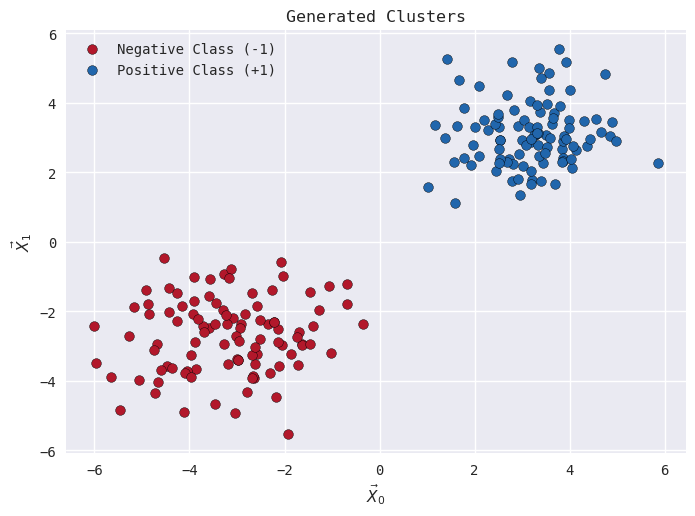

In [80]:
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], c='#b2182b', label='Negative Class (-1)', edgecolors='k')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='#2166ac', label='Positive Class (+1)', edgecolors='k')
plt.legend()
plt.xlabel('$\\vec{X}_0$')
plt.ylabel('$\\vec{X}_1$')
plt.title('Generated Clusters')
plt.show()

In [81]:
Data = TensorDataset(X, y)
Data[90:110]        # Slice of Dataset

(tensor([[-4.1183, -4.9092],
         [-4.3632, -3.6271],
         [-3.1912, -3.5099],
         [-1.8669, -3.2219],
         [-1.7270, -2.7500],
         [-3.6934, -2.6094],
         [-2.6859, -3.9119],
         [-5.4554, -4.8353],
         [-2.5142, -2.2417],
         [-2.6250, -3.0402],
         [ 4.3032,  3.4879],
         [ 4.1340,  2.6444],
         [ 3.3618,  4.9993],
         [ 3.6630,  3.7047],
         [ 3.0213,  2.1707],
         [ 1.9191,  2.2161],
         [ 3.5071,  3.0821],
         [ 3.4440,  2.2760],
         [ 2.5389,  2.9361],
         [ 1.6333,  3.3298]]),
 tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.]))

In [82]:
trainData, valData = random_split(Data, (0.8, 0.2), generator=GENERATOR)

trainLoader = DataLoader(trainData, batch_size=BATCH_SIZE, generator=GENERATOR, shuffle=True)
valLoader = DataLoader(valData, batch_size=BATCH_SIZE, generator=GENERATOR, shuffle=True)

In [ ]:
model = LinearSVM(in_dims=2).to(DEVICE)
criteria = HingeLoss(reduction='mean', is_soft=True, C=100)

print(f"Model: {model}\nLoss: {criteria}")

Model: LinearSVM(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Loss: HingeLoss()


In [84]:
trainer = Trainer(
    model,
    trainLoader,
    valLoader,
    optimizer=optim.SGD(model.parameters(), lr=.1),
    criterion=criteria,        # Soft Margin SVM
    device=DEVICE
)

In [85]:
train_loss, val_loss = trainer.train(num_epochs=NUM_EPOCHS)

Epoch 50/50 | Train Loss: 0.1828 | Val Loss: 0.1082: 100%|██████████| 50/50 [00:00<00:00, 105.34it/s]


In [86]:
print("Train Loss:", train_loss, "\nValidation Loss:", val_loss, sep='\n')

Train Loss:
{1: 9.050487232208251, 2: 2.458852481842041, 3: 0.8573487162590027, 4: 0.30767446756362915, 5: 0.19655460715293885, 6: 0.18728490471839904, 7: 0.1833177089691162, 8: 0.16870762258768082, 9: 0.1551275834441185, 10: 0.18098228573799133, 11: 0.18613314181566237, 12: 0.19121673405170442, 13: 0.19437062740325928, 14: 0.17527507841587067, 15: 0.1678369462490082, 16: 0.18253509253263472, 17: 0.17458176612854004, 18: 0.1690427228808403, 19: 0.1703346237540245, 20: 0.17491988390684127, 21: 0.23257511109113693, 22: 0.1843717634677887, 23: 0.1846925973892212, 24: 0.175796577334404, 25: 0.17033039331436156, 26: 0.17153035700321198, 27: 0.17357899844646454, 28: 0.1743887960910797, 29: 0.18585547506809236, 30: 0.17607443630695344, 31: 0.17434383928775787, 32: 0.16811261624097823, 33: 0.2214224323630333, 34: 0.17100422084331512, 35: 0.17705001384019853, 36: 0.17192446887493135, 37: 0.17006869316101075, 38: 0.18079551309347153, 39: 0.2036306917667389, 40: 0.17803678810596466, 41: 0.1800344

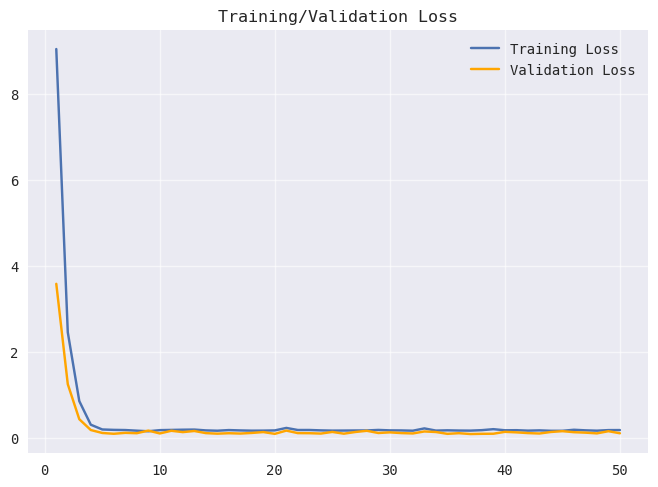

In [87]:
plt.plot(
    train_loss.keys(),
    train_loss.values(),
    label="Training Loss"
);
plt.plot(
    val_loss.keys(),
    val_loss.values(),
    color="orange",
    label="Validation Loss"
);
plt.grid(True, alpha = .6);
plt.title("Training/Validation Loss");
plt.legend(loc='best');
plt.show()

In [88]:
print(f"Predicted model Parameters:", "Weights: {}".format(model.linear.weight), "Bias: {}".format(model.linear.bias), sep="\n")

Predicted model Parameters:
Weights: Parameter containing:
tensor([[0.3045, 0.3515]], device='cuda:0', requires_grad=True)
Bias: Parameter containing:
tensor([-0.2438], device='cuda:0', requires_grad=True)


In [89]:
print(f"Shapes for Weight and Bias Tensors:", model.linear.weight.shape, model.linear.bias.shape, sep="\n")

Shapes for Weight and Bias Tensors:
torch.Size([1, 2])
torch.Size([1])


In [90]:
# Ensure model is in eval mode and on CPU for visualization
model.eval()
model.to('cpu')

# Extract weights and bias
w = model.linear.weight.detach().numpy()
b = model.linear.bias.detach().numpy()

In [91]:
# Convert X and y to NumPy arrays (for CPU processes)
Xnp = X.numpy()
ynp = y.numpy()

Xmin, Xmax = Xnp[:, 0].min() - 1, Xnp[:, 0].max() + 1
ymin, ymax = Xnp[:, 1].min() - 1, Xnp[:, 1].max() + 1
XX, yy = np.meshgrid(np.arange(Xmin, Xmax, 0.02), np.arange(ymin, ymax, 0.02))

print(f"Generated Grid of points:\n{(XX[:10], yy[:10])}")

Generated Grid of points:
(array([[-7.01145363, -6.99145363, -6.97145363, ...,  6.80854637,
         6.82854637,  6.84854637],
       [-7.01145363, -6.99145363, -6.97145363, ...,  6.80854637,
         6.82854637,  6.84854637],
       [-7.01145363, -6.99145363, -6.97145363, ...,  6.80854637,
         6.82854637,  6.84854637],
       ...,
       [-7.01145363, -6.99145363, -6.97145363, ...,  6.80854637,
         6.82854637,  6.84854637],
       [-7.01145363, -6.99145363, -6.97145363, ...,  6.80854637,
         6.82854637,  6.84854637],
       [-7.01145363, -6.99145363, -6.97145363, ...,  6.80854637,
         6.82854637,  6.84854637]]), array([[-6.52662516, -6.52662516, -6.52662516, ..., -6.52662516,
        -6.52662516, -6.52662516],
       [-6.50662516, -6.50662516, -6.50662516, ..., -6.50662516,
        -6.50662516, -6.50662516],
       [-6.48662516, -6.48662516, -6.48662516, ..., -6.48662516,
        -6.48662516, -6.48662516],
       ...,
       [-6.38662516, -6.38662516, -6.38662516, 

In [92]:

# Predictionon the entire grid
Gp = np.c_[XX.ravel(), yy.ravel()]
G = torch.from_numpy(Gp).float()        # Grid Tensor

mean = X.mean(dim=0, keepdim=True)
std = X.std(dim=0, keepdim=True)
G = (G - mean) / (std + 1e-8)

# Inference
Z = model(G)

Z = Z.detach().numpy()
Z = Z.reshape(XX.shape)

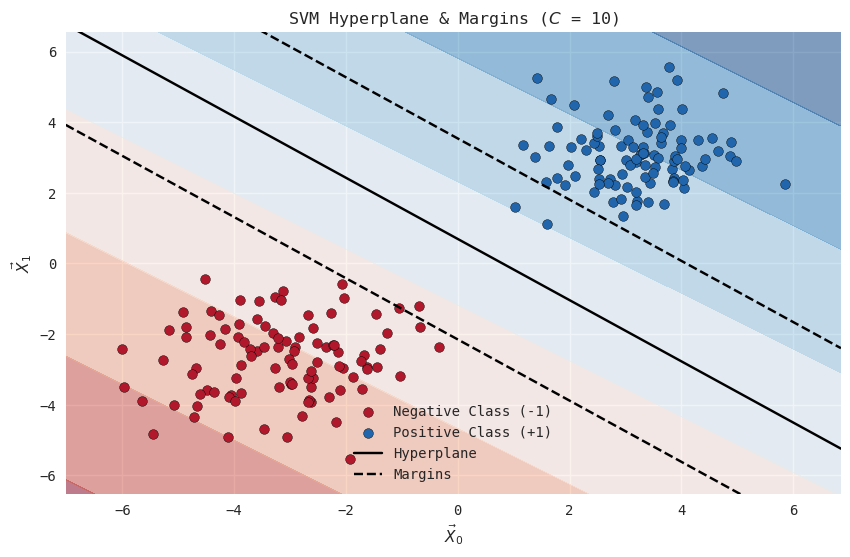

In [ ]:

plt.figure(figsize=(10, 6))
# Decision Regions
plt.contourf(XX, yy, Z, cmap=plt.cm.RdBu, alpha=0.5)
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], c='#b2182b', label='Negative Class (-1)', edgecolors='k')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='#2166ac', label='Positive Class (+1)', edgecolors='k')

# Hyperplane
x_ = np.linspace(Xmin, Xmax, 100)
y_ = (-w[0, 0] * x_ - b) / w[0, 1]

plt.plot(x_, y_, 'k-', label='Hyperplane')

# Margins
margin = 1 / np.linalg.norm(w)

y_upper = (-w[0, 0] * x_ - b + 1) / w[0, 1]
y_lower = (-w[0, 0] * x_ - b - 1) / w[0, 1]

plt.plot(x_, y_upper, 'k--', label='Margins')
plt.plot(x_, y_lower, 'k--')

plt.xlim(XX.min(), XX.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('$\\vec{X}_0$')
plt.ylabel('$\\vec{X}_1$')
plt.title('SVM Hyperplane & Margins ($C$ = 100)')
plt.legend()
plt.show()